In [2]:
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch

# Binary label mapping: 0 = cat, 1 = dog
class BinaryOxfordPet(OxfordIIITPet):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        # Oxford labels: 0-based, first 25 are cats, rest are dogs
        label = 0 if label < 25 else 1
        return image, label

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

train_dataset = BinaryOxfordPet(root="./data", split='trainval', target_types='category', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 792M/792M [02:32<00:00, 5.21MB/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19.2M/19.2M [00:08<00:00, 2.38MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x)); x = self.pool1(x)
        x = F.relu(self.conv2(x)); x = self.pool2(x)
        x = F.relu(self.conv3(x)); x = self.pool3(x)
        x = F.relu(self.conv4(x))
        self.features = x
        x = self.gap(x).squeeze(-1).squeeze(-1)
        x = self.fc(x)
        return torch.sigmoid(x)


In [4]:
model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total * 100
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {accuracy:.2f}%")


Epoch 1: Loss = 0.6393, Accuracy = 67.31%
Epoch 2: Loss = 0.6324, Accuracy = 67.42%
Epoch 3: Loss = 0.6315, Accuracy = 67.42%
Epoch 4: Loss = 0.6320, Accuracy = 67.42%
Epoch 5: Loss = 0.6319, Accuracy = 67.42%


In [5]:
torch.save(model.state_dict(), "model.pth")

In [6]:
!ls

data  model.pth  Untitled.ipynb


In [7]:
model.load_state_dict(torch.load('model.pth', map_location='cpu'))  # After training
model.eval()

# Extract weights of the final FC layer
gap_weights = model.fc.weight.detach().squeeze().numpy()  # shape: (128,)

/tmp/ipykernel_122970/1066702042.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth', map_location='cpu'))  # After training


In [8]:
def show_cam(image_tensor, features, results):
    features = features.squeeze().permute(1, 2, 0).detach().numpy()  # (H, W, C)
    pred = results.item()

    cam_features = ndi.zoom(features, (300 / features.shape[0], 300 / features.shape[1], 1), order=2)
    cam_output = np.dot(cam_features, gap_weights)

    img_np = image_tensor.squeeze().permute(1, 2, 0).numpy()

    plt.imshow(img_np, alpha=0.5)
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.title(f"Sigmoid: {pred:.2f} → {'dog' if round(pred) else 'cat'}")
    plt.axis('off')
    plt.show()


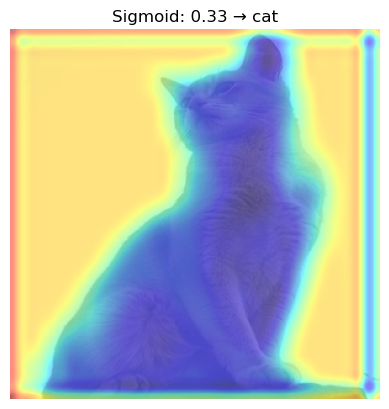

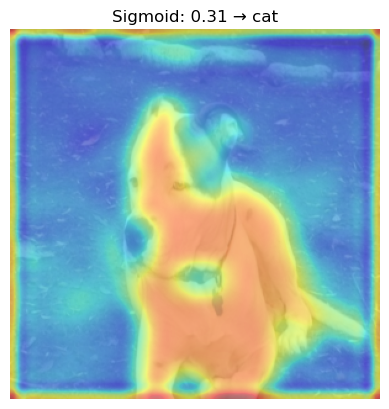

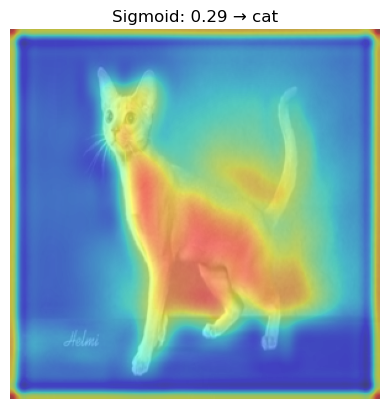

In [18]:
def convert_and_classify(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        features = model.features

    show_cam(input_tensor, features, output)

convert_and_classify('cat1.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('cat2.jpg')

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# --- Storage for conv features ---
features_blobs = []

# --- Hook on last conv layer ---
model.features[-1].register_forward_hook(lambda m, i, o: features_blobs.append(o.detach()))

# --- Get weights of final FC layer ---
fc_weights = model.classifier.weight.data.squeeze().cpu().numpy()

# --- Load one image from dataset ---
image, label = train_dataset[0]
input_tensor = image.unsqueeze(0).to(device)

# --- Forward pass ---
model.eval()
features_blobs.clear()
output = model(input_tensor)
pred = torch.sigmoid(output).item()

# --- Get conv features ---
feature_map = features_blobs[0].squeeze(0).cpu().numpy()  # shape: (128, H, W)

# --- Compute CAM ---
cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
for i in range(len(fc_weights)):
    cam += fc_weights[i] * feature_map[i]

cam = np.maximum(cam, 0)
cam = cam / cam.max()

# --- Resize to input image size (300x300) ---
cam_resized = scipy.ndimage.zoom(cam, (300 / cam.shape[0], 300 / cam.shape[1]), order=2)

# --- Plot only CAM ---
plt.imshow(cam_resized, cmap='jet')
plt.title("Class Activation Map")
plt.axis("off")
plt.show()


AttributeError: 'Tensor' object has no attribute 'register_forward_hook'

In [19]:
import torch
import matplotlib.pyplot as plt

def show_saliency_map(model, image_tensor, label=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    image_tensor.requires_grad_()  # Enable gradient tracking

    output = model(image_tensor)
    score = output.squeeze()  # Scalar prediction

    model.zero_grad()
    score.backward()  # Backprop to get gradients w.r.t. input image

    saliency = image_tensor.grad.data.abs().squeeze()  # Take absolute value of gradients

    # Take maximum across color channels
    saliency, _ = torch.max(saliency, dim=0)

    # Plot
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor.squeeze().permute(1, 2, 0).cpu().detach().numpy())
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(saliency.cpu(), cmap='hot')
    plt.title("Saliency Map")

    if label is not None:
        print(f"True label: {'Dog' if label == 1 else 'Cat'} - Prediction: {output.item():.4f}")

    plt.tight_layout()
    plt.show()


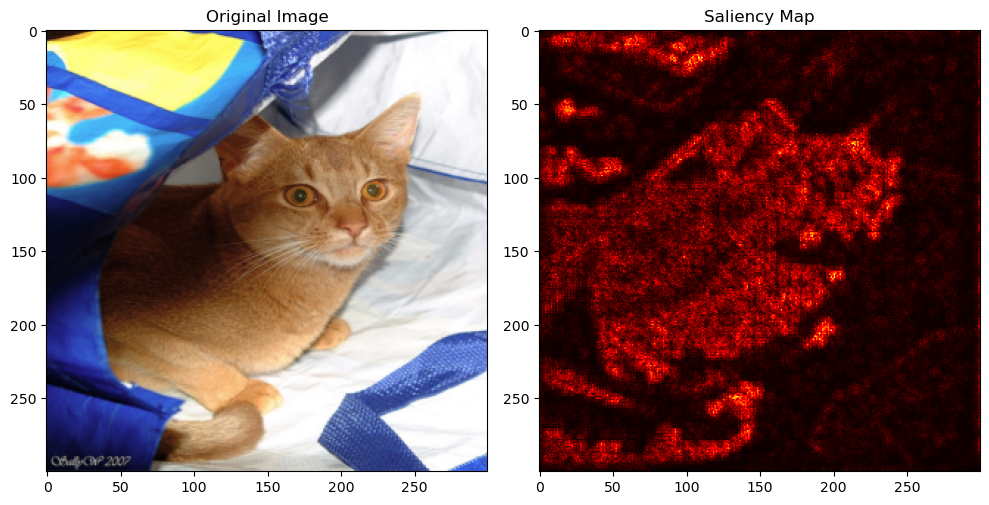

In [21]:
image, label = train_dataset[0]  # change index if needed
image = image.to(device)


show_saliency_map(model, image)